## Анализ и прогнозирование временных рядов методами искусственного интеллекта

### **Практическая работа 3. Поиск аномалий во временных рядах.**


#### **3.1 Поиск диссонансов с помощью алгоритма HotSAX**

##### 3.1.1 Загрузка и подготовка данных

В данной будет использоваться временной ряд, состоящий из показаний акселерометра. 
Анализируемый временной ряд, описывает две активности человека - бег и шаг.


In [ ]:
!pip install scipy
!pip install scikit-learn

In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from time import time
import pandas as pd

In [2]:
#fixme: Путь
dataset_dir_path = Path('datasets')
data_path = dataset_dir_path/'walk_run.txt'
walk_run = np.loadtxt(data_path)[3000:4000]
data = walk_run
size_sub = 50

В середине временного ряда происходит смена активности (бег заменяет шаг). Нетипичным поведением, которое мы могли бы назвать диссонансами в данном ряде выступает небольшой участок между активностями, когда человек плавно увеличивает скорость шага до бега. В ходе данной работе наша задача выделить с помощью различных алгоритмов границы нашего диссонанса.

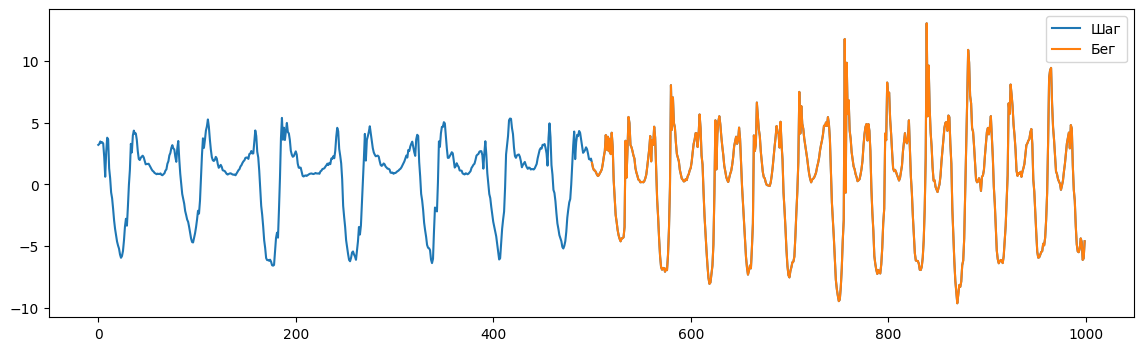

In [3]:
fig, ax =  plt.subplots(figsize=(14,4),ncols=1,nrows=1)
plt.plot(data[:],label='Шаг')
plt.plot(np.arange(data.shape[0]//2,data.shape[0]),data[data.shape[0]//2:],label='Бег')
plt.legend()

In [4]:
result={}
times={}

##### 3.1.2 Реализация полного перебора

Приводится пример кода для нахождения топ 5 диссонансов с помощью реализации полного беребора.
Вам необходимо добавить код для сбора времени обработки данных.

In [5]:
from modules.saxpy.discord import find_discords_brute_force
start = time()
discords_brute_force= np.stack(find_discords_brute_force(data[:], 50, 5))
end = time()

##### 3.1.3 HotSAX

Используя [реализацию](https://github.com/seninp/saxpy/blob/master/saxpy/hotsax.py) найдите топ 5 диссонансов ряда.
Произведите замер времени работы.

In [6]:
# INSERT YOUR CODE

##### 3.1.4 Визаулизация

Вам необходимо реализовать код позволяющий:
1. Вывести на одном графике ряд и его диссонансы
2. Столбчатую диаграмму времени работы обоих алгоритмов
   
Постройте графики для обоих алгоритмов и сравните полученные результаты.

Пример графика:

![first_graf](pics/fig_ex_1.png)

In [ ]:
# INSERT YOUR CODE

In [7]:
from matplotlib.patches import Rectangle

##### 3.1.5 Такси NY

Произведите поиск диссонансов с помощью обоих алгоритмов на наборе данных, содержащим информацию о среднем числе пассажиров в NY. Отобразите найденные диссонансы обоими алгоритмами. 

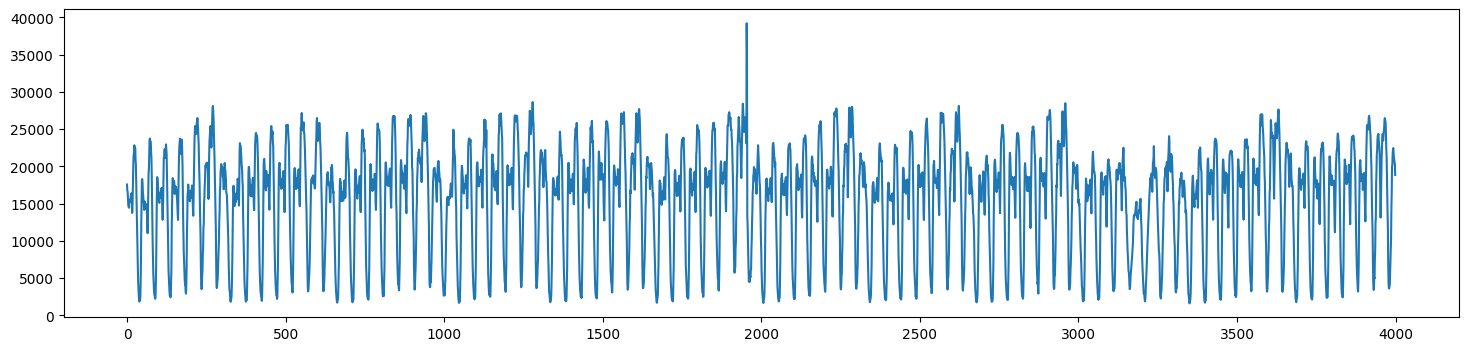

In [4]:
nyc_taxi = pd.read_csv(dataset_dir_path/'nyc_taxi.csv',index_col=0).values[4000:8000,0].astype(np.float64)
fig = plt.figure(figsize=(18, 4))
plt.plot(nyc_taxi)

# INSERT YOUR CODE

#### **3.2 Поиск диссонансов с помощью алгоритма DRAG**

In [ ]:
!pip install stumpy==1.11.1

In [6]:
import stumpy
from stumpy import core, config
from stumpy.scrump import _prescrump


Как мы помним из лекций:

**Диапазонный диссонанс** – подпоследовательность ряда, расстояние от которой до ее ближайшего соседа не ниже заданного порога. 

Основными параметрами при поисках диссонансов являются:
- $m$ - длина диссонанса
- $r$ - пороговое значение расстояния подпоследовательности ряда, до его ближайшего соседа


In [7]:
from modules.drag import find_candidates, DRAG


Для поиска диссонансов в данной части практической работы мы воспользуемся алгоритмом **DRAG (Discord Range Aware Gathering)**.
Для начала воспользуемся данным алгоритмом, чтобы найти диссонансы в наборе данных содержащем активность человека.

In [8]:
data = walk_run

Длину искомого диссонанса, как и для предыдущих алгоритмов, мы установим равно 50 точек.
Пороговое значение мы установим равным большим, чтобы узнать, как алгоритм отреагирует на большие значения данного параметра.

In [9]:
m = 50 
r = 10
idxs, _, _ = DRAG(data,m,r)
print(f'Колличество найденных диссонансов: {len(idxs)}')

Колличество найденных диссонансов: 0


Как вы можете видеть мы установили слишком большое пороговое значение, алгоритму не удалось выделить ни одного диссонанса. Попробуем уменьшить пороговое значение до 1, чтобы улучшить результат. 

In [10]:
m = 50 
r = 1
idxs, _, _ = DRAG(data, m, r)
print(f'Колличество найденных диссонансов: {len(idxs)}')

Колличество найденных диссонансов: 50


При такой комбинации параметров, улучшить ситуацию не получилось. Алгоритм выделил слишком большое количество диссонансов, часть которых является ложными диссонансами и не будут информативными для нас.

Произведите подобные эксперименты с набором данных такси NY. Постройте графики демонстрирующие найденные диссонансы. Пример Графика:
![second-graph](pics/fig_ex_2.png)

In [ ]:
# INSERT YOUR CODE

Чтобы разобраться, почему так происходит и как работает данный алгоритм, ниже мы реализуем все этапы алгоритма DRAG.

Как мы помним из лекций алгоритм DRAG содержит два этапа:

1. Отбор - За одно сканирование ряда сформировать множество кандидатов в диссонансы.
2. Очистка - За одно сканирование ряда отбросить кандидатов, которые являются ложными диссонансами.

##### 3.2.1 Отбор кандидатов

Первым этапом обработки данных является отбор множества потенциальных кандидатов. Мы выбираем из всего множества подпоследовательностей ряда такие, для которых расстояние до правых ближайших соседей больше параметра $r$.

In [11]:
#выбирем более реальное значение для порога
r = 3

In [12]:
T, M_T, Σ_T = core.preprocess(data, m)
#формируем массив длинной равной длине  исходного ряда - m + 1, 
#элемент массива является истинным, 
#в том случае если подпоследовательность является потенциальным кандидатом
is_cands = find_candidates(T, m, M_T, Σ_T, r, init_cands=None, right=True)
#находим индексы потенциальных кандидатов
cand_index = np.flatnonzero(is_cands)

In [13]:
print(f'{len(cand_index)} {len(cand_index)/len(data)*100} %')

113 11.3 %


Во время отбора кандидатов нам удалось выделить около 113 подпоследовательностей(около 11.3%), которые мы бы могли назвать потенциальными диссонансами.
Это большой процент, который не может нас устраивать как конечный результат.
Если посмотреть на рисунок ниже, мы увидим, что большая часть потенциальных диссонансов расположена в районе смены активности. 
К сожалению пресутсвуют и ложные диссонансы, которые случайным образом попали в данный список.

Сформируйте график найденных диссонансов

In [ ]:
# INSERT YOUR CODE

##### 3.2.2 Очистка кандидатов
Как уже упоминалось выше, 11.3% слишком большой процент диссонансов.
Для уменьшения числа потенциальных кандидатов произведем очистку от ложных диссонансов, путем сравнения расстояния до левых ближайших соседей потенциальных диссонансов с порогом $r$.


In [14]:
is_cands = find_candidates(T, m, M_T, Σ_T, r, init_cands=is_cands, right=False)
cands = np.flatnonzero(is_cands)

In [15]:
len(cands)/len(data)*100

2.9000000000000004

Сформируйте график найденных диссонансов

In [ ]:
# INSERT YOUR CODE

Нам удалось сократить число диссонансов до 2.9%. Если проанализировать рисунок, то можно заметить, что большая их часть является тривиальными повторениями подпоследовательности в области смены активности. На следующем шаге избавимся от них.

In [16]:
from modules.drag import refine_candidates
discords_idx, discords_dist, discords_nn_idx = refine_candidates(T, m, M_T, Σ_T, is_cands)
len(discords_idx)/len(data)*100

0.8999999999999999

Сформируйте график найденных диссонансов

In [ ]:
# INSERT YOUR CODE

##### 3.2.3 Подбор параметров

Реализуйте перебор параметров $m$ и $r$. Подберете параметры таким образом, чтобы алгоритм обнаружил только те диссонансы, которые связаны со сменой активности. Сделайте вывод о том, как эти параметры влияют на качество работы модели.
Подберите оптимальные параметры алгоритма для набора данных такси NY. 
Визуализируйте результаты для разных комбинаций. Сделайте выводы.


In [ ]:
# INSERT YOUR CODE

#### **3.3 Поиск диссонансов с помощью алгоритма Merlin**

Как мы уже выяснили подбирать параметры для DRAG простым перебором не очень удобно. Для оптимизации данного процесса в статье [1] был предложен алгоритм Merlin для оптимального поиска подходящего порогового значения.

Условно мы можем разделить поиск диссонансов на три шага:

1. Поиск диссонансов минимальной длинны $minL$. На данном шаге $r = 2\sqrt{minL}$.
2. Поиск диссонансов следующих четырех длин. На данном шаге $r = 0.99 \cdot nndist_{m-1}$. Где $nndist_{m-1}$ - расстояние до ближайшего соседа предыдущего найденного диссонанса.
3. Поиск диссонансов всех 
оставшихся дли. $r = \mu - 2 \sigma$. Средние значение и стандартное отклонение вычисляются из расстояний 5 предыдущих диссонансов. н

[1] Nakamura T., Imamura M., Mercer R., Keogh E.J. MERLIN: parameter-free discovery of arbitrary length anomalies in massive time series archives. 20th IEEE Int. Conf. on Data Mining, ICDM 2020, Sorrento, Italy, November 17-20, 2020. pp. 1190-1195. IEEE (2020). https://doi.org/10.1109/ICDM50108.2020.00147

##### 3.3.1 Поиск диссонансов минимальной длинны

Вспомнил последовательность действий первого шага алгоритма:
![merlin-part-first](pics/first_part.png)

В данной работе мы внесем небольшое изменение, мы будем считать, что подпоследовательность может быть диссонансом только в том случае, если больше 75% точек, не входят в состав других диссонансов. 

In [17]:
T = walk_run
m = 50
# сформируем массив метод для потенциальных кандидатов в диссонансы.
# после каждого найденного диссонанса, 
# мы будем исключать окружающие его подпоследовательности из числа потенциальных кандидатов,
# путем замены значений их меток на false
excl_zone = int(np.ceil(m / 4))
include = np.ones(len(T)-m+1, dtype=bool)
# Количество диссонансов, которые мы будем искать
topK = 10


In [18]:
dis_idx = -np.ones((topK))
dis_nnDist = -np.ones((topK))
dis_nn_idx = np.full((topK),-np.inf)
#первое прближение r
r = 2*np.sqrt(m)
minL = m
maxL = int(m+np.ceil(m*0.1))
#количество найденных диссонасов
cound_find_dis = 0

while dis_nnDist[cound_find_dis-1]<0 and cound_find_dis<topK:
    result = DRAG(data=T,m=minL,r=r, include =include)
    for diss, nnDist, nn in zip(*result):
        dis_idx[cound_find_dis] = diss
        dis_nnDist[cound_find_dis] = nnDist
        dis_nn_idx[cound_find_dis] = nn
        #исключаем окружающие найденный диссонас 
        #подпоследовательности и числа потенциальных диссонасов
        core.apply_exclusion_zone(include, diss, excl_zone, False)
        cound_find_dis+=1
        if cound_find_dis>=topK:
            break
    r*=0.5

In [19]:
maxL

55

In [170]:
print('Количество найденных на первом этапе диссонансов:', cound_find_dis)

Количество найденных на первом этапе диссонансов: 2


На первом шаге нам удалось выделить 2 диссонанса из 10 требуемых. 
Реализуйте, оставшиеся шаги алгоритма, чтобы найти оставшиеся диссонансы. 

![merlin-part-first](pics/second_part.png)


In [ ]:
# INSERT YOUR CODE

Найдите диссонансы набора такси NY. Визуализируйте найденные диссонансы для обоих наборов данных, сравните с результатами остальных методов. 


In [ ]:
# INSERT YOUR CODE